In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Corrected dataset path (no space)
dataset_path = '/content/drive/MyDrive/DS_PROJECT/DS_PROJECT/SolarGuard/dataset/dataset'

In [8]:
import zipfile
import os

zip_paths = [
    f'{dataset_path}/Bird-drop-20250428T115508Z-1-001.zip',
    f'{dataset_path}/Clean-20250428T115502Z-1-001.zip',
    f'{dataset_path}/Dusty-20250428T115457Z-1-001.zip',
    f'{dataset_path}/Electrical-damage-20250428T115452Z-1-001.zip',
    f'{dataset_path}/Physical-Damage-20250428T115448Z-1-001.zip',
    f'{dataset_path}/Snow-Covered-20250428T115440Z-1-001.zip',
]

for zip_file in zip_paths:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
        image_files = [f for f in zip_ref.namelist() if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        print(f"{zip_file.split('/')[-1]} → {len(image_files)} image(s)")

Bird-drop-20250428T115508Z-1-001.zip → 207 image(s)
Clean-20250428T115502Z-1-001.zip → 193 image(s)
Dusty-20250428T115457Z-1-001.zip → 190 image(s)
Electrical-damage-20250428T115452Z-1-001.zip → 103 image(s)
Physical-Damage-20250428T115448Z-1-001.zip → 69 image(s)
Snow-Covered-20250428T115440Z-1-001.zip → 123 image(s)


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 224, 224
batch_size = 32

datagen = train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

num_classes = train_generator.num_classes

Found 711 images belonging to 6 classes.
Found 174 images belonging to 6 classes.


In [10]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze for feature extraction

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=predictions)

mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

mobilenet_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
mobilenet_history = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7446 - loss: 0.7674 - val_accuracy: 0.8046 - val_loss: 0.6234
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.7918 - loss: 0.6141 - val_accuracy: 0.7816 - val_loss: 0.6262
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.8397 - loss: 0.5052 - val_accuracy: 0.8218 - val_loss: 0.5559
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8024 - loss: 0.5204 - val_accuracy: 0.8103 - val_loss: 0.5533
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8875 - loss: 0.3874 - val_accuracy: 0.8391 - val_loss: 0.5198
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8728 - loss: 0.3731 - val_accuracy: 0.7931 - val_loss: 0.5722
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8962 - loss: 0.3137 - val_accuracy: 0.8391 - val_loss: 0.4967
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.9113 - loss: 0.2692 - val_accuracy: 0.8276 - val_loss:

In [13]:
# Evaluate MobileNetV2 model on validation data
mobilenet_loss, mobilenet_accuracy = mobilenet_model.evaluate(val_generator)
print(f"MobileNetV2 Model Accuracy: {mobilenet_accuracy * 100:.2f}%")


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8369 - loss: 0.4791
MobileNetV2 Model Accuracy: 83.91%


In [15]:
import matplotlib.pyplot as plt


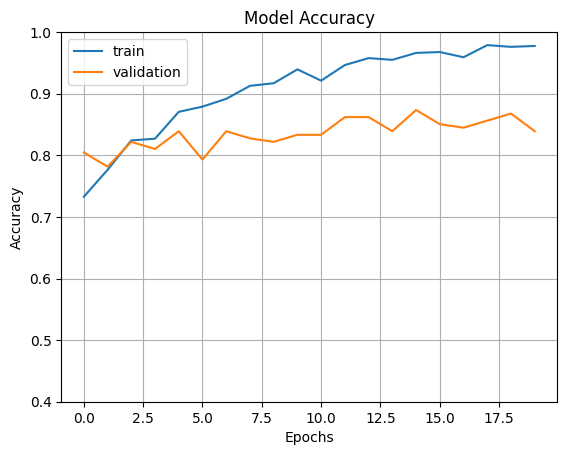

In [17]:
fig =plt.gcf()
plt.plot(mobilenet_history.history['accuracy'])
plt.plot(mobilenet_history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'])
plt.show()

In [18]:
mobilenet_model.save('/content/drive/MyDrive/DS_PROJECT/DS_PROJECT/SolarGuard/mobile_net.h5')